In [4]:
import numpy as np
import xarray as xr
import math
import matplotlib.pyplot as plt
from datetime import datetime

%matplotlib inline

In [5]:
plt.rcParams['font.size'] = 12

In [6]:
results_path = '/scratch/bmoorema/Results/test/SalishSeaCast_currenttuning_test'

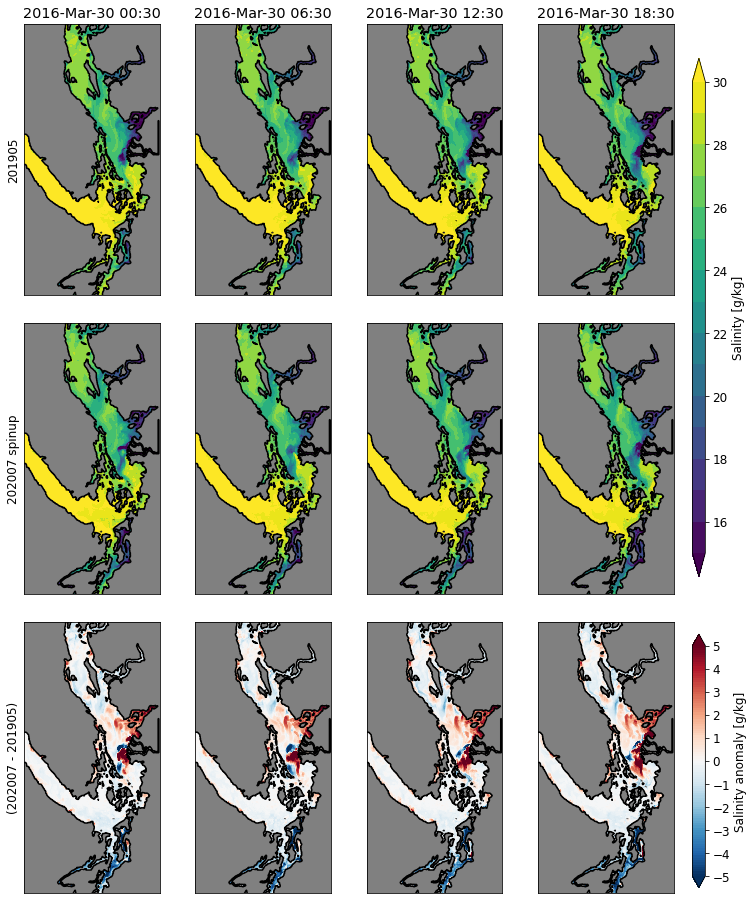

In [24]:
mask = xr.open_dataset('/home/bmoorema/MEOPAR/grid/mesh_mask202108.nc')
T_old = xr.open_dataset(results_path + '/SalishSea_1h_20160330_20160330_grid_T.nc')
T_new = xr.open_dataset(results_path + '/SalishSea_1h_20160101_20160331_grid_T.nc').isel(time_counter=slice(-24, None))
tmask = mask.tmask[0, 0, 1:, 1:].values

fig, axs = plt.subplots(3, 4, figsize=(12, 16), gridspec_kw={'wspace': 0.1, 'hspace': 0.1})
axs[0, 0].set_ylabel('201905')
axs[1, 0].set_ylabel('202007 spinup')
axs[2, 0].set_ylabel('(202007 - 201905)')

for row, t in zip(axs.T, range(0, 24, 6)):

    timestr = T_new.time_counter.isel(time_counter=t).values.astype('datetime64[s]').astype(datetime).strftime('%Y-%b-%d %H:%M')
    salinity = [T.vosaline.isel(time_counter=t, deptht=0).values for T in (T_old, T_new)]
    
    for ax, sal in zip(row, salinity):
        c1 = ax.contourf(sal, levels=np.arange(15, 31), cmap='viridis', extend='both')
    
    c2 = row[2].contourf(np.subtract(*salinity[::-1]), levels=np.arange(-5, 5.1, 0.1), cmap='RdBu_r', extend='both')
    
    row[0].set_title(timestr)
    for ax in row:
        ax.contourf(tmask, levels=[-0.01, 0.01], colors='gray')
        ax.contour(tmask, levels=[-0.01, 0.01], colors='k')
        ax.set_ylim([50, 750])
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        ax.set_aspect(5/4.4)

cax = fig.add_axes([0.91, 0.4, 0.015, 0.45])
fig.colorbar(c1, cax=cax, label='Salinity [g/kg]', ticks=range(16, 31, 2))

cax = fig.add_axes([0.91, 0.13, 0.015, 0.22])
fig.colorbar(c2, cax=cax, label='Salinity anomaly [g/kg]', ticks=range(-5, 6))